In [1]:
import qutip as qt
import pandas as pd
import numpy as np

import os
import glob

from scipy.optimize import minimize_scalar


In [2]:

# list the folders in ../data
folders = glob.glob("../data/*")

folders = [f for f in folders if "1qb" in f]

# sort the folders by name
folders.sort()

folders


['../data/2025-05-15--14h-39m--2025-05-15--14h-43m_1qb_tomo_sagnac2_40mW_A_nominally_H',
 '../data/2025-05-15--14h-43m--2025-05-15--14h-46m_1qb_tomo_sagnac2_40mW_A_nominally_V',
 '../data/2025-05-15--14h-46m--2025-05-15--14h-49m_1qb_tomo_sagnac2_40mW_A_nominally_D',
 '../data/2025-05-15--14h-49m--2025-05-15--14h-52m_1qb_tomo_sagnac2_40mW_A_nominally_R',
 '../data/2025-05-15--14h-52m--2025-05-15--14h-55m_1qb_tomo_sagnac2_40mW_A_nominally_A',
 '../data/2025-05-15--14h-56m--2025-05-15--14h-58m_1qb_tomo_sagnac2_40mW_A_nominally_L',
 '../data/2025-05-15--15h-01m--2025-05-15--15h-04m_1qb_tomo_sagnac2_40mW_B_nominally_H',
 '../data/2025-05-15--15h-04m--2025-05-15--15h-07m_1qb_tomo_sagnac2_40mW_B_nominally_V',
 '../data/2025-05-15--15h-07m--2025-05-15--15h-10m_1qb_tomo_sagnac2_40mW_B_nominally_D',
 '../data/2025-05-15--15h-10m--2025-05-15--15h-13m_1qb_tomo_sagnac2_40mW_B_nominally_R',
 '../data/2025-05-15--15h-13m--2025-05-15--15h-16m_1qb_tomo_sagnac2_40mW_B_nominally_A',
 '../data/2025-05-15-

In [3]:
def extract_reconstructed_state(data, key="reconstructed_state"):

    matrix_11 = data[key][0][0]['real'] + 1j * data[key][0][0]['imag']
    matrix_12 = data[key][0][1]['real'] + 1j * data[key][0][1]['imag']
    matrix_21 = data[key][1][0]['real'] + 1j * data[key][1][0]['imag']
    matrix_22 = data[key][1][1]['real'] + 1j * data[key][1][1]['imag']

    matrix = [[matrix_11, matrix_12],
                [matrix_21, matrix_22]]
    return qt.Qobj(matrix, dims=[[2], [2]])



In [4]:
# for each folder, load the data in .../R/tomography_resutls.json and .../T/tomography_results.json

reconstructed_states = []

for folder in folders:
    last_part_of_folder = folder.split("/")[-1]

    # folder names like 2025-05-13--16h-29m--2025-05-13--16h-30m_1qb_tomo_sagnac2_40mW_B_nominally_H
    # extract the parameters from the folder name

    params = last_part_of_folder.split("_")
    nominal_state_name = params[-1]
    launcher = params[-3]
    laser_power = params[-4]

    R_file = os.path.join(folder, "R", "tomography_results.json")
    T_file = os.path.join(folder, "T", "tomography_results.json")

    if not os.path.exists(R_file) or not os.path.exists(T_file):
        print(f"Skipping {folder} because one of the files does not exist")
        continue

    R_data = pd.read_json(R_file)
    T_data = pd.read_json(T_file)

    rho_R = extract_reconstructed_state(R_data)
    rho_T = extract_reconstructed_state(T_data)
    
    target_state = extract_reconstructed_state(T_data, key="target_state")

    reconstructed_states.append({
        "folder": folder,
        "nominal_state_name": nominal_state_name,
        "launcher": launcher,
        "laser_power": laser_power,
        "reconstructed_state_T": rho_T,
        "reconstructed_state_R": rho_R,
        "target_state": target_state
    })

reconstructed_states[-1]['reconstructed_state_T']



Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.50672687+0.j         -0.09841196-0.48023621j]
 [-0.09841196+0.48023621j  0.49327313+0.j        ]]

In [5]:
def density_to_bloch_coords(rho):
    x = np.real((rho * qt.Qobj([[0, 1], [1, 0]])).tr())  # ⟨σx⟩
    y = np.real((rho * qt.Qobj([[0, -1j], [1j, 0]])).tr())  # ⟨σy⟩
    z = np.real((rho * qt.Qobj([[1, 0], [0, -1]])).tr())  # ⟨σz⟩
    return [x, y, z]


bloch = density_to_bloch_coords(reconstructed_states[0]['reconstructed_state_T'])
bloch

[0.012094440209242, 0.023165432393326003, 0.9838256404351461]

In [6]:
# add the bloch coordinates to the reconstructed states
for state in reconstructed_states:
    bloch_coords_T = density_to_bloch_coords(state['reconstructed_state_T'])
    state['bloch_coords_T'] = bloch_coords_T
    bloch_coords_R = density_to_bloch_coords(state['reconstructed_state_R'])
    state['bloch_coords_R'] = bloch_coords_R

reconstructed_states[0]['bloch_coords_T']

[0.012094440209242, 0.023165432393326003, 0.9838256404351461]

In [14]:
# D
reconstructed_states[2]['bloch_coords_T']

[0.96569527575816, -0.15729032272668803, 0.08150205069910699]

In [15]:
# A
reconstructed_states[4]['bloch_coords_T']

[-0.958460678972304, 0.24078126005904402, 0.048871199147537014]

In [ ]:
# L
reconstructed_states[5]['bloch_coords_T']

[0.18948859512914001, 0.9692268578463761, 0.05378647702621503]

In [ ]:
reconstructed_states[5]['reconstructed_state_T'] * reconstructed_states[5]['bloch_coords_T']

{'folder': '../data/2025-05-15--14h-56m--2025-05-15--14h-58m_1qb_tomo_sagnac2_40mW_A_nominally_L',
 'nominal_state_name': 'L',
 'launcher': 'A',
 'laser_power': '40mW',
 'reconstructed_state_T': Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.52689324+0.j         0.0947443 -0.48461343j]
  [0.0947443 +0.48461343j 0.47310676+0.j        ]],
 'reconstructed_state_R': Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 0.48836415+0.j         -0.13474841-0.47318369j]
  [-0.13474841+0.47318369j  0.51163585+0.j        ]],
 'target_state': Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.5+0.j  0. -0.5j]
  [0. +0.5j 0.5+0.j ]],
 'bloch_coords_T': [0.18948859512914001,
  0.9692268578463761,
  0.05378647702621503],
 'bloch_coords_R': [-0.26949682704641803,
  0.9463673862125841,
  -0.023271694808040977]}

In [11]:
# R
reconstructed_states[3]['bloch_coords_T']

[0.17725913817283, 0.97057427818338, 0.034691531904300965]

H


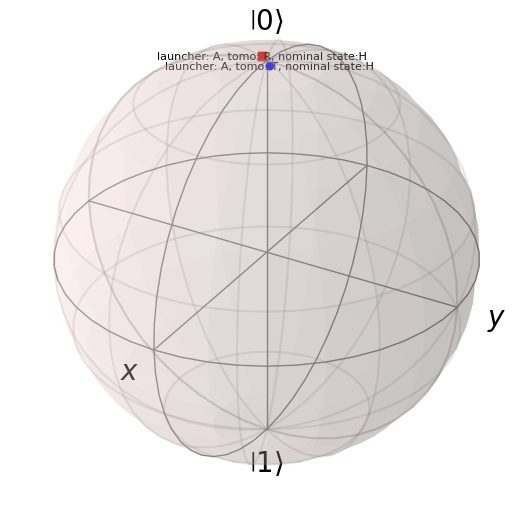

V


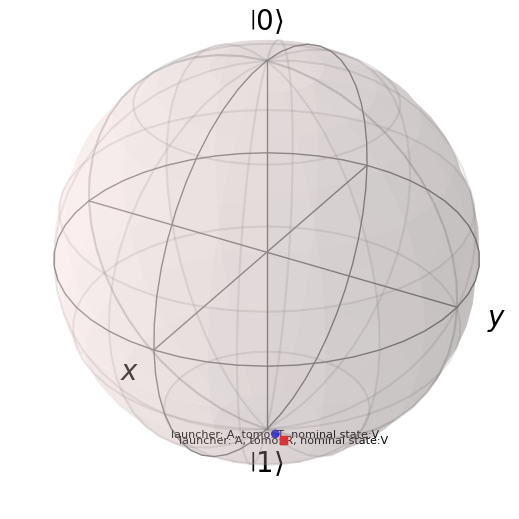

D


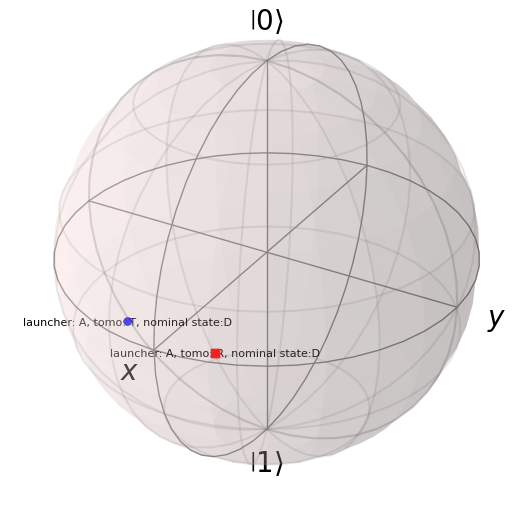

R


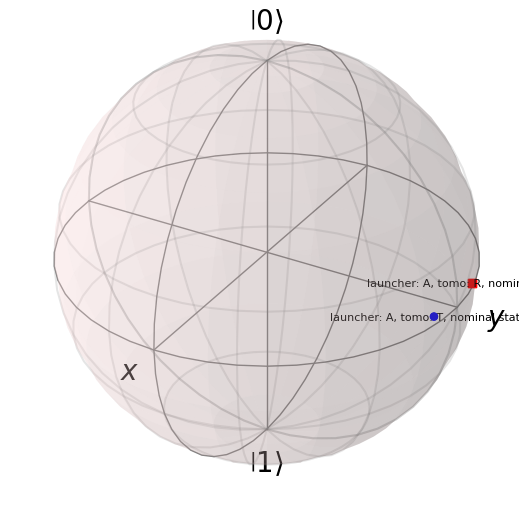

A


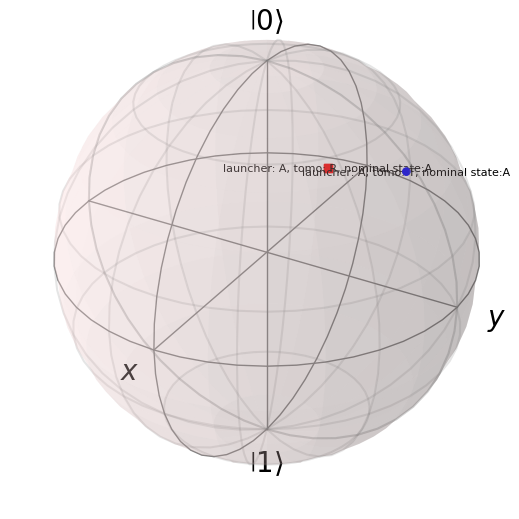

L


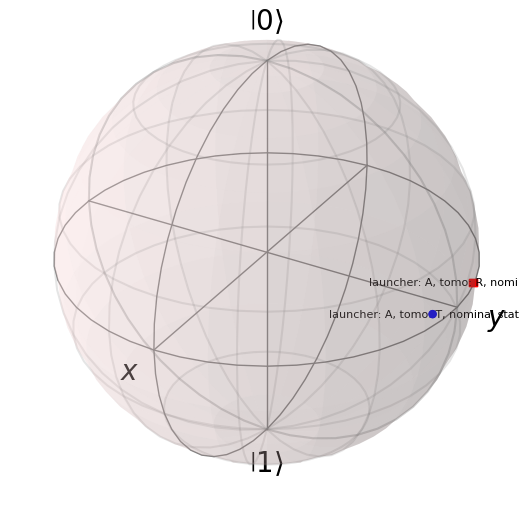

H


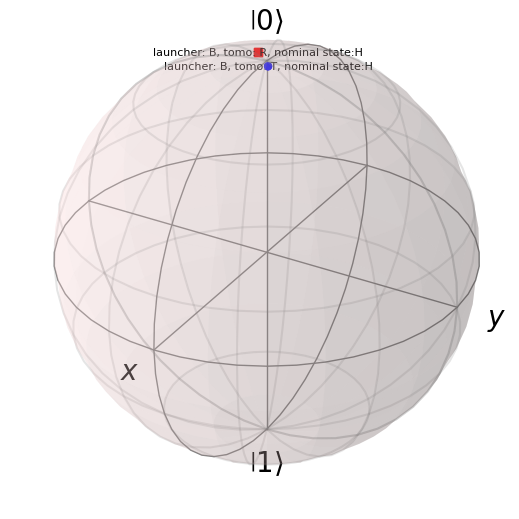

V


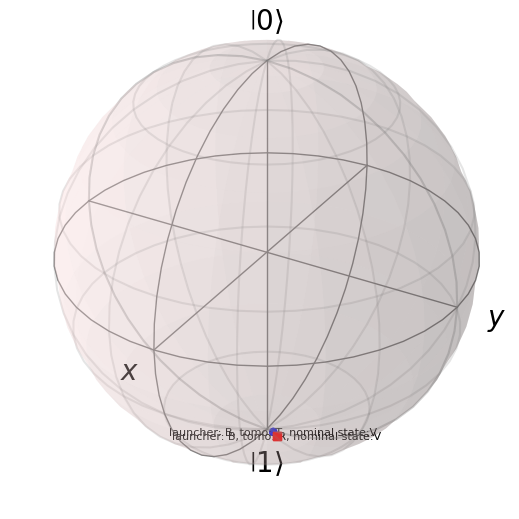

D


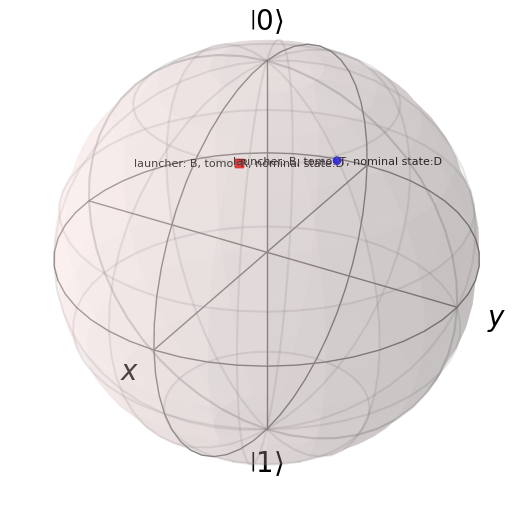

R


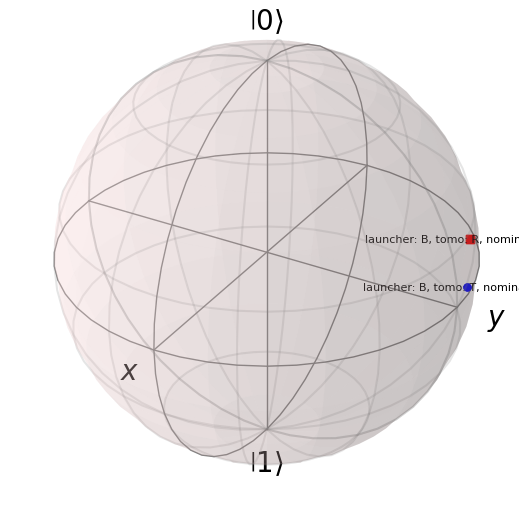

A


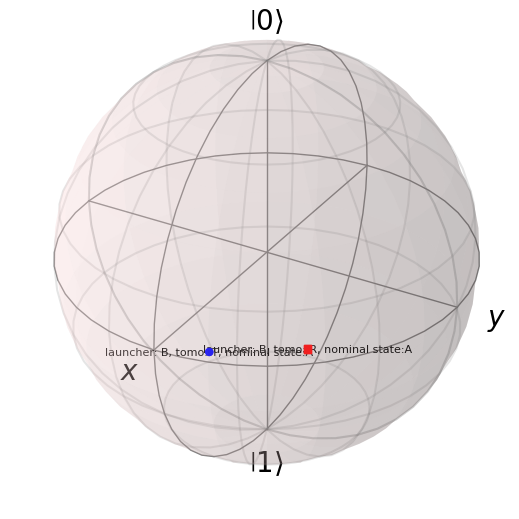

L


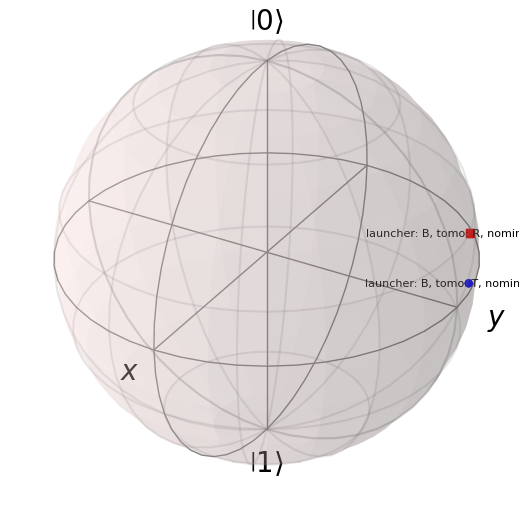

In [8]:
# b = qt.Bloch()
# bloch_coords_T = state['bloch_coords_T']
# b.add_points(bloch_coords_T)

# b.add_annotation(bloch_coords_T, state['launcher'] + "T")

# bloch_coords_R = state['bloch_coords_R']
# b.add_points(bloch_coords_R)

# b.add_annotation(bloch_coords_R, state['launcher'] + "R")

# Add points
for state in reconstructed_states:
    # new bloch sphere for each state
    b = qt.Bloch()
    # make the image bigger
    b.make_sphere()
    bloch_coords_T = state['bloch_coords_T']
    b.add_points(bloch_coords_T)
    print(state["nominal_state_name"])
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8)
    bloch_coords_R = state['bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8)

    # Display
    b.show()

In [18]:
import state_preparation.waveplates as sp

In [28]:
R = qt.Qobj([1/np.sqrt(2), 1/np.sqrt(2) *1j], dims=[[2], [1]])
L = qt.Qobj([1/np.sqrt(2), -1/np.sqrt(2) *1j], dims=[[2], [1]])

r_hwp_qwp = sp.get_hwp_qwp_from_target_state(R)
l_hwp_qwp = sp.get_hwp_qwp_from_target_state(L)

In [32]:
theta = 0.1
ket = R = qt.Qobj([1, np.exp(1j*theta)], dims=[[2], [1]]).unit()

In [34]:
np.degrees(sp.get_hwp_qwp_from_target_state(ket))

array([21.06760551, 45.        ])

In [31]:
np.degrees(l_hwp_qwp)

array([22.5,  0. ])

In [25]:
h = qt.basis(2, 0)  # |0>
v = qt.basis(2, 1)  # |1>

initial_state = h.unit()  # |H>

target_state = (h + 1j * v).unit()  # |H> + i|V>

theta_hwp, theta_qwp = sp.get_hwp_qwp_from_target_state(target_state)

theta_hwp, theta_qwp

(np.float64(-0.39269908169872414), np.float64(0.0))